# Numerical Stability and Initialization
:label:`sec_numerical_stability`


Thus far, every model that we have implemented
required that we initialize its parameters
according to some pre-specified distribution.
Until now, we took the initialization scheme for granted,
glossing over the details of how these choices are made.
You might have even gotten the impression that these choices
are not especially important.
On the contrary, the choice of initialization scheme
plays a significant role in neural network learning,
and it can be crucial for maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the nonlinear activation function.
Which function we choose and how we initialize parameters
can determine how quickly our optimization algorithm converges.
Poor choices here can cause us to encounter
exploding or vanishing gradients while training.
In this section, we delve into these topics in greater detail
and discuss some useful heuristics
that you will find useful
throughout your career in deep learning.


到目前为止，我们实现的所有模型都需要按照某种预先指定的分布来初始化参数。直到现在，我们都把初始化方案视为理所当然的，忽略了这些选择的具体细节。你甚至可能产生了这些选择并不重要的印象。然而事实恰恰相反，初始化方案的选择在神经网络学习中起着重要作用，对保持数值稳定性至关重要。此外，这些选择可以与非线性激活函数的选择以有趣的方式相关联。我们选择哪个函数以及如何初始化参数可以决定优化算法的收敛速度。这里的不当选择可能导致我们在训练过程中遇到梯度爆炸或梯度消失的问题。本节我们将更深入地探讨这些主题，并讨论一些在深度学习生涯中会派上用场的实用启发式方法。

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Vanishing and Exploding Gradients

Consider a deep network with $L$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
With each layer $l$ defined by a transformation $f_l$
parametrized by weights $\mathbf{W}^{(l)}$,
whose hidden layer output is $\mathbf{h}^{(l)}$ (let $\mathbf{h}^{(0)} = \mathbf{x}$),
our network can be expressed as:

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \textrm{ and thus } \mathbf{o} = f_L \circ \cdots \circ f_1(\mathbf{x}).$$

If all the hidden layer output and the input are vectors,
we can write the gradient of $\mathbf{o}$ with respect to
any set of parameters $\mathbf{W}^{(l)}$ as follows:

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\textrm{def}}{=}} \cdots \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\textrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\textrm{def}}{=}}.$$

In other words, this gradient is
the product of $L-l$ matrices
$\mathbf{M}^{(L)} \cdots \mathbf{M}^{(l+1)}$
and the gradient vector $\mathbf{v}^{(l)}$.
Thus we are susceptible to the same
problems of numerical underflow that often crop up
when multiplying together too many probabilities.
When dealing with probabilities, a common trick is to
switch into log-space, i.e., shifting
pressure from the mantissa to the exponent
of the numerical representation.
Unfortunately, our problem above is more serious:
initially the matrices $\mathbf{M}^{(l)}$ may have a wide variety of eigenvalues.
They might be small or large, and
their product might be *very large* or *very small*.

The risks posed by unstable gradients
go beyond numerical representation.
Gradients of unpredictable magnitude
also threaten the stability of our optimization algorithms.
We may be facing parameter updates that are either
(i) excessively large, destroying our model
(the *exploding gradient* problem);
or (ii) excessively small
(the *vanishing gradient* problem),
rendering learning impossible as parameters
hardly move on each update.


### (**Vanishing Gradients**)

One frequent culprit causing the vanishing gradient problem
is the choice of the activation function $\sigma$
that is appended following each layer's linear operations.
Historically, the sigmoid function
$1/(1 + \exp(-x))$ (introduced in :numref:`sec_mlp`)
was popular because it resembles a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that fire either *fully* or *not at all*
(like biological neurons) seemed appealing.
Let's take a closer look at the sigmoid
to see why it can cause vanishing gradients.


## 梯度消失与爆炸

考虑一个具有$L$层的深度网络，输入为$\mathbf{x}$，输出为$\mathbf{o}$。每层$l$由变换$f_l$定义（由权重$\mathbf{W}^{(l)}$参数化），其隐藏层输出为$\mathbf{h}^{(l)}$（令$\mathbf{h}^{(0)} = \mathbf{x}$），我们的网络可以表示为：

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \quad 因此 \quad \mathbf{o} = f_L \circ \cdots \circ f_1(\mathbf{x}).$$

如果所有隐藏层输出和输入都是向量，我们可以写出$\mathbf{o}$相对于任何参数集$\mathbf{W}^{(l)}$的梯度：

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\textrm{def}}{=}} \cdots \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\textrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\textrm{def}}{=}}.$$

换句话说，这个梯度是$L-l$个矩阵$\mathbf{M}^{(L)} \cdots \mathbf{M}^{(l+1)}$与梯度向量$\mathbf{v}^{(l)}$的乘积。因此我们容易遇到与概率连乘时类似的数值下溢问题。处理概率时常用的技巧是转换到对数空间，即将压力从数值表示的尾数转移到指数。但遗憾的是，我们这里的问题更严重：初始矩阵$\mathbf{M}^{(l)}$可能具有各种不同的特征值，可能很小或很大，它们的乘积可能*非常大*或*非常小*。

梯度不稳定性带来的风险不仅限于数值表示。梯度幅度的不可预测性还会威胁优化算法的稳定性。我们可能面临两种参数更新情况：
1. 过大的更新，破坏模型（梯度爆炸问题）
2. 过小的更新（梯度消失问题），导致参数几乎不更新

### （**梯度消失**）

导致梯度消失问题的常见原因是激活函数$\sigma$的选择。历史上，s型函数$1/(1 + \exp(-x))$（在 :numref:`sec_mlp` 中介绍）之所以流行，是因为它类似于阈值函数。由于早期人工神经网络受生物神经网络启发，神经元"全有或全无"（像生物神经元）的激活方式看起来很吸引人。让我们仔细看看s型函数为何会导致梯度消失。

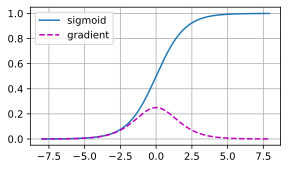

In [5]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

As you can see, (**the sigmoid's gradient vanishes
both when its inputs are large and when they are small**).
Moreover, when backpropagating through many layers,
unless we are in the Goldilocks zone, where
the inputs to many of the sigmoids are close to zero,
the gradients of the overall product may vanish.
When our network boasts many layers,
unless we are careful, the gradient
will likely be cut off at some layer.
Indeed, this problem used to plague deep network training.
Consequently, ReLUs, which are more stable
(but less neurally plausible),
have emerged as the default choice for practitioners.


### [**Exploding Gradients**]

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw 100 Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
When this happens because of the initialization
of a deep network, we have no chance of getting
a gradient descent optimizer to converge.


正如所见，（**当输入值较大或较小时，sigmoid函数的梯度都会消失**）。此外，当通过多层进行反向传播时，除非许多sigmoid函数的输入都位于接近零的黄金区域（Goldilocks zone），否则整个乘积的梯度可能会消失。当我们的网络具有许多层时，除非我们特别谨慎，否则梯度很可能在某一层被切断。事实上，这个问题曾长期困扰深度网络训练。因此，更稳定的ReLU函数（虽然神经科学上的合理性较低），已成为从业者的默认选择。

### [**梯度爆炸**]

相反的问题——梯度爆炸也同样令人困扰。为了更好地说明这一点，我们绘制100个高斯随机矩阵，并将其与某个初始矩阵相乘。对于我们选择的尺度（方差$\sigma^2=1$的设定），矩阵乘积会发生爆炸式增长。当这种情况由于深度网络的初始化导致时，我们根本无法让梯度下降优化器收敛。

In [6]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-2.1174, -1.0516,  0.9085, -1.2130],
        [-1.4169, -1.5462, -1.8316, -2.0007],
        [-0.8093, -0.1414,  0.8263,  0.2757],
        [-1.0319, -0.0540,  1.0882,  0.1225]])
after multiplying 100 matrices
 tensor([[ 7.0710e+23,  9.2268e+23,  4.0304e+23, -1.4237e+24],
        [-2.6674e+24, -3.4806e+24, -1.5204e+24,  5.3707e+24],
        [ 9.0452e+23,  1.1803e+24,  5.1556e+23, -1.8212e+24],
        [ 1.4409e+24,  1.8802e+24,  8.2128e+23, -2.9012e+24]])


### Breaking the Symmetry

Another problem in neural network design
is the symmetry inherent in their parametrization.
Assume that we have a simple MLP
with one hidden layer and two units.
In this case, we could permute the weights $\mathbf{W}^{(1)}$
of the first layer and likewise permute
the weights of the output layer
to obtain the same function.
There is nothing special differentiating
the first and second hidden units.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Consider the aforementioned one-hidden-layer MLP
with two hidden units.
For illustration,
suppose that the output layer transforms the two hidden units into only one output unit.
Imagine what would happen if we initialized
all the parameters of the hidden layer
as $\mathbf{W}^{(1)} = c$ for some constant $c$.
In this case, during forward propagation
either hidden unit takes the same inputs and parameters
producing the same activation
which is fed to the output unit.
During backpropagation,
differentiating the output unit with respect to parameters $\mathbf{W}^{(1)}$ gives a gradient all of whose elements take the same value.
Thus, after gradient-based iteration (e.g., minibatch stochastic gradient descent),
all the elements of $\mathbf{W}^{(1)}$ still take the same value.
Such iterations would
never *break the symmetry* on their own
and we might never be able to realize
the network's expressive power.
The hidden layer would behave
as if it had only a single unit.
Note that while minibatch stochastic gradient descent would not break this symmetry,
dropout regularization (to be introduced later) would!


## Parameter Initialization

One way of addressing---or at least mitigating---the
issues raised above is through careful initialization.
As we will see later,
additional care during optimization
and suitable regularization can further enhance stability.


### Default Initialization

In the previous sections, e.g., in :numref:`sec_linear_concise`,
we used a normal distribution
to initialize the values of our weights.
If we do not specify the initialization method, the framework will
use a default random initialization method, which often works well in practice
for moderate problem sizes.






### Xavier Initialization
:label:`subsec_xavier`

Let's look at the scale distribution of
an output $o_{i}$ for some fully connected layer
*without nonlinearities*.
With $n_\textrm{in}$ inputs $x_j$
and their associated weights $w_{ij}$ for this layer,
an output is given by

$$o_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j.$$

The weights $w_{ij}$ are all drawn
independently from the same distribution.
Furthermore, let's assume that this distribution
has zero mean and variance $\sigma^2$.
Note that this does not mean that the distribution has to be Gaussian,
just that the mean and variance need to exist.
For now, let's assume that the inputs to the layer $x_j$
also have zero mean and variance $\gamma^2$
and that they are independent of $w_{ij}$ and independent of each other.
In this case, we can compute the mean of $o_i$:

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\textrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\textrm{in}} E[w_{ij}] E[x_j] \\&= 0, \end{aligned}$$

and the variance:

$$
\begin{aligned}
    \textrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\textrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

One way to keep the variance fixed
is to set $n_\textrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the layers closer to the output.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\textrm{out} \sigma^2 = 1$,
where $n_\textrm{out}$ is the number of outputs of this layer.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\textrm{in} + n_\textrm{out}) \sigma^2 = 1 \textrm{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}.
\end{aligned}
$$

This is the reasoning underlying the now-standard
and practically beneficial *Xavier initialization*,
named after the first author of its creators :cite:`Glorot.Bengio.2010`.
Typically, the Xavier initialization
samples weights from a Gaussian distribution
with zero mean and variance
$\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$.
We can also adapt this to
choose the variance when sampling weights
from a uniform distribution.
Note that the uniform distribution $U(-a, a)$ has variance $\frac{a^2}{3}$.
Plugging $\frac{a^2}{3}$ into our condition on $\sigma^2$
prompts us to initialize according to

$$U\left(-\sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}, \sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}\right).$$

Though the assumption for nonexistence of nonlinearities
in the above mathematical reasoning
can be easily violated in neural networks,
the Xavier initialization method
turns out to work well in practice.


### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
A deep learning framework often implements over a dozen different heuristics.
Moreover, parameter initialization continues to be
a hot area of fundamental research in deep learning.
Among these are heuristics specialized for
tied (shared) parameters, super-resolution,
sequence models, and other situations.
For instance,
:citet:`Xiao.Bahri.Sohl-Dickstein.ea.2018` demonstrated the possibility of training
10,000-layer neural networks without architectural tricks
by using a carefully-designed initialization method.

If the topic interests you we suggest
a deep dive into this module's offerings,
reading the papers that proposed and analyzed each heuristic,
and then exploring the latest publications on the topic.
Perhaps you will stumble across or even invent
a clever idea and contribute an implementation to deep learning frameworks.


## Summary

Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
Random initialization is key to ensuring that symmetry is broken before optimization.
Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs.
ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.

## Exercises

1. Can you design other cases where a neural network might exhibit symmetry that needs breaking, besides the permutation symmetry in an MLP's layers?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on layerwise adaptive rate scaling  for inspiration :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)


### 打破对称性

神经网络设计中的另一个问题是其参数化所固有的对称性。假设我们有一个简单的MLP，具有一个隐藏层和两个单元。在这种情况下，我们可以置换第一层的权重 $\mathbf{W}^{(1)}$，同时置换输出层的权重，以获得相同的函数。第一和第二隐藏单元之间没有任何特殊的区别。换句话说，我们在每一层的隐藏单元之间存在置换对称性。

这不仅仅是一个理论上的麻烦。考虑上述具有两个隐藏单元的单隐藏层MLP。为了说明问题，假设输出层将两个隐藏单元转换为仅一个输出单元。想象一下，如果我们将隐藏层的所有参数初始化为 $\mathbf{W}^{(1)} = c$（某个常数 $c$）会发生什么。在这种情况下，在前向传播期间，任一隐藏单元接收相同的输入和参数，产生相同的激活，然后输入到输出单元。在反向传播过程中，相对于参数 $\mathbf{W}^{(1)}$ 对输出单元进行微分得到的梯度，其所有元素取相同的值。因此，经过基于梯度的迭代（例如，小批量随机梯度下降）后，$\mathbf{W}^{(1)}$ 的所有元素仍然取相同的值。这样的迭代永远不会自行*打破对称性*，我们可能永远无法实现网络的表达能力。隐藏层将表现得好像它只有一个单元。请注意，虽然小批量随机梯度下降不会打破这种对称性，但dropout正则化（稍后将介绍）会做到这一点！

## 参数初始化

解决或至少缓解上述问题的一种方法是通过谨慎的初始化。正如我们稍后将看到的，在优化过程中的额外注意和适当的正则化可以进一步增强稳定性。

### 默认初始化

在前面的章节中，例如在 :numref:`sec_linear_concise` 中，我们使用正态分布来初始化权重的值。如果我们不指定初始化方法，框架将使用默认的随机初始化方法，这在中等规模的问题上通常效果良好。

### Xavier初始化
:label:`subsec_xavier`

让我们看看*没有非线性*的全连接层输出 $o_{i}$ 的尺度分布。对于这一层的 $n_\textrm{in}$ 个输入 $x_j$ 及其相关权重 $w_{ij}$，输出由下式给出：

$$o_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j.$$

权重 $w_{ij}$ 都是从同一分布中独立抽取的。此外，假设这个分布的均值为零，方差为 $\sigma^2$。请注意，这并不意味着分布必须是高斯分布，只是需要均值和方差存在。现在，假设该层的输入 $x_j$ 也具有零均值和方差 $\gamma^2$，并且它们与 $w_{ij}$ 互相独立，也相互独立。在这种情况下，我们可以计算 $o_i$ 的均值：

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\textrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\textrm{in}} E[w_{ij}] E[x_j] \\&= 0, \end{aligned}$$

以及方差：

$$
\begin{aligned}
    \textrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\textrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

保持方差固定的一种方法是设置 $n_\textrm{in} \sigma^2 = 1$。现在考虑反向传播。在反向传播中，我们面临类似的问题，尽管梯度是从更接近输出的层传播的。使用与前向传播相同的推理，我们看到除非 $n_\textrm{out} \sigma^2 = 1$（其中 $n_\textrm{out}$ 是该层的输出数量），否则梯度的方差可能会爆炸。这使我们陷入困境：我们不可能同时满足这两个条件。相反，我们只是尝试满足：

$$
\begin{aligned}
\frac{1}{2} (n_\textrm{in} + n_\textrm{out}) \sigma^2 = 1 \textrm{ 或等价地 }
\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}.
\end{aligned}
$$

这就是现在标准的且在实践中有益的*Xavier初始化*的基本原理，以其创造者的第一作者命名 :cite:`Glorot.Bengio.2010`。通常，Xavier初始化从均值为零、方差为 $\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$ 的高斯分布中采样权重。我们也可以适应这一点，在从均匀分布中采样权重时选择方差。注意，均匀分布 $U(-a, a)$ 的方差为 $\frac{a^2}{3}$。将 $\frac{a^2}{3}$ 代入我们对 $\sigma^2$ 的条件，提示我们按照以下方式初始化：

$$U\left(-\sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}, \sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}\right).$$

尽管上述数学推理中对非线性不存在的假设在神经网络中很容易被违反，但Xavier初始化方法在实践中表现良好。

### 更多进展

上面的推理仅仅触及了现代参数初始化方法的表面。深度学习框架通常实现十几种不同的启发式方法。此外，参数初始化继续是深度学习基础研究的热门领域。其中包括为绑定（共享）参数、超分辨率、序列模型和其他情况专门设计的启发式方法。例如，:citet:`Xiao.Bahri.Sohl-Dickstein.ea.2018` 证明了通过使用精心设计的初始化方法，可以训练10,000层神经网络而无需架构技巧。

如果这个话题使你感兴趣，我们建议深入研究这个模块的内容，阅读提出和分析每种启发式方法的论文，然后探索该主题的最新出版物。也许你会偶然发现甚至发明一个聪明的想法，并为深度学习框架贡献一个实现。

## 总结

消失和爆炸梯度是深度网络中常见的问题。需要在参数初始化时格外小心，以确保梯度和参数保持良好控制。需要初始化启发式方法来确保初始梯度既不太大也不太小。随机初始化是确保在优化之前打破对称性的关键。Xavier初始化建议，对于每一层，任何输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。ReLU激活函数缓解了梯度消失问题。这可以加速收敛。

## 练习

1. 你能设计出神经网络可能表现出需要打破的对称性的其他情况吗，除了MLP层中的置换对称性之外？
2. 我们可以在线性回归或softmax回归中将所有权重参数初始化为相同的值吗？
3. 查找两个矩阵乘积特征值的解析边界。这告诉你什么关于确保梯度良好调节的信息？
4. 如果我们知道某些项发散，我们能事后修复这个问题吗？查看关于层级自适应率缩放的论文以获取灵感 :cite:`You.Gitman.Ginsburg.2017`。


<think>我需要更详细地解释神经网络中梯度方差的计算过程。让我从基础开始，逐步推导出梯度的方差是如何计算的，以及为什么在Xavier初始化中需要考虑输出数量。

首先，我会明确网络结构，然后分析反向传播时梯度的传递和方差变化。</think># 神经网络中梯度方差的详细计算

在神经网络中，理解梯度方差的计算对于解决梯度消失和爆炸问题至关重要。我将详细解释这个过程。

## 基本设置

考虑一个全连接网络层，输入为 $\mathbf{x}$ (维度为 $n_\textrm{in}$)，输出为 $\mathbf{o}$ (维度为 $n_\textrm{out}$)，权重矩阵为 $\mathbf{W}$。

前向传播计算：
$$o_i = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j$$

## 反向传播中的梯度计算

假设我们有损失函数 $L$，我们关心 $\frac{\partial L}{\partial w_{ij}}$ 的方差。

应用链式法则：
$$\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial o_i} \cdot \frac{\partial o_i}{\partial w_{ij}} = \frac{\partial L}{\partial o_i} \cdot x_j$$

这里 $\frac{\partial L}{\partial o_i}$ 是从上层反向传播过来的梯度。

## 梯度方差的详细推导

让我们定义以下符号：
- $\delta_i = \frac{\partial L}{\partial o_i}$：反向传播到该层输出的梯度
- $g_{ij} = \frac{\partial L}{\partial w_{ij}}$：权重 $w_{ij}$ 的梯度

假设：
1. $\delta_i$ 的均值为0，方差为 $\textrm{Var}[\delta_i] = v_\delta$
2. 输入 $x_j$ 的均值为0，方差为 $\textrm{Var}[x_j] = \gamma^2$
3. $\delta_i$ 和 $x_j$ 相互独立

那么我们可以计算 $g_{ij}$ 的方差：

$$\begin{aligned}
\textrm{Var}[g_{ij}] &= \textrm{Var}[\delta_i \cdot x_j] \\
&= E[(\delta_i \cdot x_j)^2] - (E[\delta_i \cdot x_j])^2 \\
&= E[\delta_i^2 \cdot x_j^2] - (E[\delta_i] \cdot E[x_j])^2 \\
&= E[\delta_i^2] \cdot E[x_j^2] - 0 \quad \text{(因为均值为0)} \\
&= \textrm{Var}[\delta_i] \cdot \textrm{Var}[x_j] \\
&= v_\delta \cdot \gamma^2
\end{aligned}$$

## 梯度方差在网络中的传播

现在考虑更完整的情况，看看上一层的梯度 $\delta_i$ 如何依赖于再上一层的梯度。

对于下一层的某个单元 $k$，它的输入是当前层的输出 $o_i$：
$$z_k = \sum_{i=1}^{n_\textrm{out}} v_{ki} \cdot o_i$$

其中 $v_{ki}$ 是下一层的权重。使用链式法则：
$$\delta_i = \frac{\partial L}{\partial o_i} = \sum_{k=1}^{n_{\textrm{next}}} \frac{\partial L}{\partial z_k} \cdot \frac{\partial z_k}{\partial o_i} = \sum_{k=1}^{n_{\textrm{next}}} \delta_k^{\textrm{next}} \cdot v_{ki}$$

其中 $\delta_k^{\textrm{next}}$ 是下一层的梯度，$n_{\textrm{next}}$ 是下一层的单元数（在我们的上下文中是 $n_\textrm{out}$）。

假设 $\delta_k^{\textrm{next}}$ 的方差为 $v_{\delta}^{\textrm{next}}$，且权重 $v_{ki}$ 的方差为 $\sigma^2$，则：

$$\begin{aligned}
\textrm{Var}[\delta_i] &= \textrm{Var}\left[\sum_{k=1}^{n_{\textrm{next}}} \delta_k^{\textrm{next}} \cdot v_{ki}\right] \\
&\approx \sum_{k=1}^{n_{\textrm{next}}} \textrm{Var}[\delta_k^{\textrm{next}} \cdot v_{ki}] \quad \text{(假设各项独立)} \\
&= \sum_{k=1}^{n_{\textrm{next}}} v_{\delta}^{\textrm{next}} \cdot \sigma^2 \\
&= n_{\textrm{next}} \cdot v_{\delta}^{\textrm{next}} \cdot \sigma^2
\end{aligned}$$

## Xavier初始化的推导

在Xavier初始化中，我们希望梯度方差在网络中保持稳定传播。换句话说：
$$\textrm{Var}[\delta_i] = v_{\delta}^{\textrm{next}}$$

代入上式：
$$n_{\textrm{next}} \cdot v_{\delta}^{\textrm{next}} \cdot \sigma^2 = v_{\delta}^{\textrm{next}}$$

简化得到：
$$n_{\textrm{next}} \cdot \sigma^2 = 1$$

由于我们的网络是双向的（前向传播和反向传播），我们既要考虑前向传播时维持输出方差（$n_\textrm{in} \cdot \sigma^2 = 1$），又要考虑反向传播时维持梯度方差（$n_\textrm{out} \cdot \sigma^2 = 1$）。

Xavier提出的折中方案是：
$$\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$$

这就是Xavier初始化的理论基础。

通过这种方式，我们可以保证无论网络多深，信号和梯度都能以适当的尺度传播，避免梯度消失或爆炸问题。

我现在来用中文解释这些内容。
</thinking>

# 神经网络中梯度方差的详细计算

## 基本设置

我们首先考虑一个简单的全连接层，其中输入是 $\mathbf{x}$（维度为 $n_\textrm{in}$），权重是 $\mathbf{W}$，输出是 $\mathbf{o}$（维度为 $n_\textrm{out}$）。对于输出的第 $i$ 个单元：

$$o_i = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j$$

## 梯度的计算

在反向传播中，我们需要计算损失函数 $L$ 对权重 $w_{ij}$ 的偏导数：

$$\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial o_i} \cdot \frac{\partial o_i}{\partial w_{ij}} = \frac{\partial L}{\partial o_i} \cdot x_j$$

这里 $\frac{\partial L}{\partial o_i}$ 是从输出层反向传播回来的梯度。

## 梯度方差的推导

为简化表示，我们定义：
- $\delta_i = \frac{\partial L}{\partial o_i}$：反向传播到该层的梯度
- $g_{ij} = \frac{\partial L}{\partial w_{ij}}$：权重的梯度

假设：
1. $\delta_i$ 均值为0，方差为 $v_\delta$
2. 输入 $x_j$ 均值为0，方差为 $\gamma^2$
3. $\delta_i$ 和 $x_j$ 相互独立

计算梯度 $g_{ij}$ 的方差：

$$\begin{aligned}
\textrm{Var}[g_{ij}] &= \textrm{Var}[\delta_i \cdot x_j] \\
&= E[(\delta_i \cdot x_j)^2] - (E[\delta_i \cdot x_j])^2 \\
&= E[\delta_i^2 \cdot x_j^2] - (E[\delta_i] \cdot E[x_j])^2 \\
&= E[\delta_i^2] \cdot E[x_j^2] - 0 \cdot 0 \\
&= v_\delta \cdot \gamma^2
\end{aligned}$$

## 梯度方差在网络中的传播

关键问题是：$\delta_i$ 的方差 $v_\delta$ 是如何受到网络结构影响的？

考虑从下一层（更接近输出层）传回的梯度。如果下一层有 $n_\textrm{out}$ 个单元，每个单元 $k$ 的输入是：

$$z_k = \sum_{i=1}^{n_\textrm{in}} v_{ki} \cdot o_i$$

其中 $v_{ki}$ 是下一层的权重。应用链式法则：

$$\delta_i = \frac{\partial L}{\partial o_i} = \sum_{k=1}^{n_\textrm{out}} \frac{\partial L}{\partial z_k} \cdot \frac{\partial z_k}{\partial o_i} = \sum_{k=1}^{n_\textrm{out}} \delta_k^{\textrm{next}} \cdot v_{ki}$$

假设下一层梯度 $\delta_k^{\textrm{next}}$ 的方差为 $v_{\delta}^{\textrm{next}}$，权重 $v_{ki}$ 的方差为 $\sigma^2$，则：

$$\begin{aligned}
\textrm{Var}[\delta_i] &= \textrm{Var}\left[\sum_{k=1}^{n_\textrm{out}} \delta_k^{\textrm{next}} \cdot v_{ki}\right] \\
&\approx \sum_{k=1}^{n_\textrm{out}} \textrm{Var}[\delta_k^{\textrm{next}} \cdot v_{ki}] \quad \text{(假设各项独立)} \\
&= \sum_{k=1}^{n_\textrm{out}} v_{\delta}^{\textrm{next}} \cdot \sigma^2 \\
&= n_\textrm{out} \cdot v_{\delta}^{\textrm{next}} \cdot \sigma^2
\end{aligned}$$

## Xavier初始化的理论依据

为了保持梯度在反向传播过程中既不消失也不爆炸，我们希望：

$$\textrm{Var}[\delta_i] = v_{\delta}^{\textrm{next}}$$

这意味着：
$$n_\textrm{out} \cdot \sigma^2 = 1$$

结合前向传播的条件（$n_\textrm{in} \cdot \sigma^2 = 1$），Xavier提出了折中方案：

$$\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$$

这就是为什么Xavier初始化需要同时考虑输入和输出神经元的数量，保证信号在网络中正向和反向传播时都保持适当的尺度。
